# 1 - Import library

---

In [170]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from shapely.geometry import Point
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brasil-real-estate/Brasile-real-estate-dataset.csv


# 2 - Reading Dataset
---

In [171]:
df = pd.read_csv('/kaggle/input/brasil-real-estate/Brasile-real-estate-dataset.csv', encoding='latin1')

df.drop(df.columns[0],axis=1, inplace = True)

display(df)

,property_type,state,region,lat,lon,area_m2,price_brl
0,apartment,Pernambuco,Northeast,-8.134204,-34.906326,72.0,414222.98
1,apartment,Pernambuco,Northeast,-8.126664,-34.903924,136.0,848408.53
2,apartment,Pernambuco,Northeast,-8.125550,-34.907601,75.0,299438.28
3,apartment,Pernambuco,Northeast,-8.120249,-34.895920,187.0,848408.53
4,apartment,Pernambuco,Northeast,-8.142666,-34.906906,80.0,464129.36
...,...,...,...,...,...,...,...
12828,house,So Paulo,Southeast,-23.587495,-46.559401,250.0,429194.89
12829,apartment,So Paulo,Southeast,-23.522029,-46.189290,55.0,252398.80
12830,apartment,So Paulo,Southeast,-23.526443,-46.529182,57.0,319400.84
12831,house,Tocantins,North,-8.848399,-48.511164,NaN,529007.65


# 3 - Treating Dataset
---

## 3.1 Null values

In [172]:
print(df.isnull().sum())

property_type       0
state               0
region              0
lat                 0
lon                 0
area_m2          1540
price_brl           0
dtype: int64


In [173]:
df = df.dropna()

In [204]:
df = df.reset_index(drop=True)

## 3.2 Checking Columns

In [174]:
print("Columns:", df.columns.tolist())

Columns: ['property_type', 'state', 'region', 'lat', 'lon', 'area_m2', 'price_brl']


### 3.2.1 Categorical

In [175]:
df['property_type'].value_counts()

property_type
apartment    8838
house        2455
Name: count, dtype: int64

In [176]:
df['state'].value_counts()

state
So Paulo              2656
Rio Grande do Sul      2643
Rio de Janeiro         2642
Santa Catarina         2634
Pernambuco              318
Rio Grande do Norte     302
Sergipe                  68
Piau                    24
Rondnia                  5
Tocantins                 1
Name: count, dtype: int64

In [177]:
df.loc[df['state'] == 'So Paulo', 'state'] = 'Sao Paulo'
df.loc[df['state'] == 'Piau', 'state'] = 'Piaui'
df.loc[df['state'] == 'Rondnia', 'state'] = 'Rondonia'

In [178]:
df['region'].value_counts()

region
Southeast    5298
South        5277
Northeast     712
North           6
Name: count, dtype: int64

### 3.2.2 Numerical

In [179]:
df.describe()

,lat,lon,area_m2,price_brl
count,11293.000000,11293.000000,11293.000000,1.129300e+04
mean,-24.709566,-46.766914,113.306916,6.648971e+05
std,5.348853,4.205313,47.225496,3.467642e+05
min,-33.692432,-63.905184,53.000000,2.395506e+05
25%,-27.750971,-49.263866,75.000000,3.892698e+05
50%,-23.687193,-46.845531,101.000000,5.707783e+05
75%,-22.956369,-43.360840,140.000000,8.501095e+05
max,-5.044685,-34.841721,252.000000,1.676854e+06


array([[<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>],
       [<Axes: title={'center': 'area_m2'}>,
        <Axes: title={'center': 'price_brl'}>]], dtype=object)

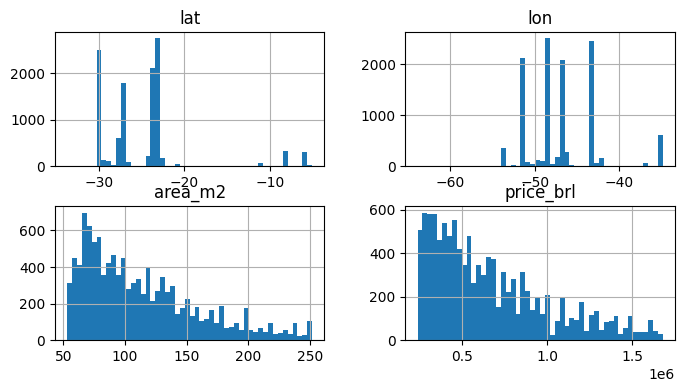

In [180]:
df.hist(bins=50, figsize=(8,4))

# 4 - Analyse
---

## 4.1 Map Lat and Lon distribution

/tmp/ipykernel_36/3465620571.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


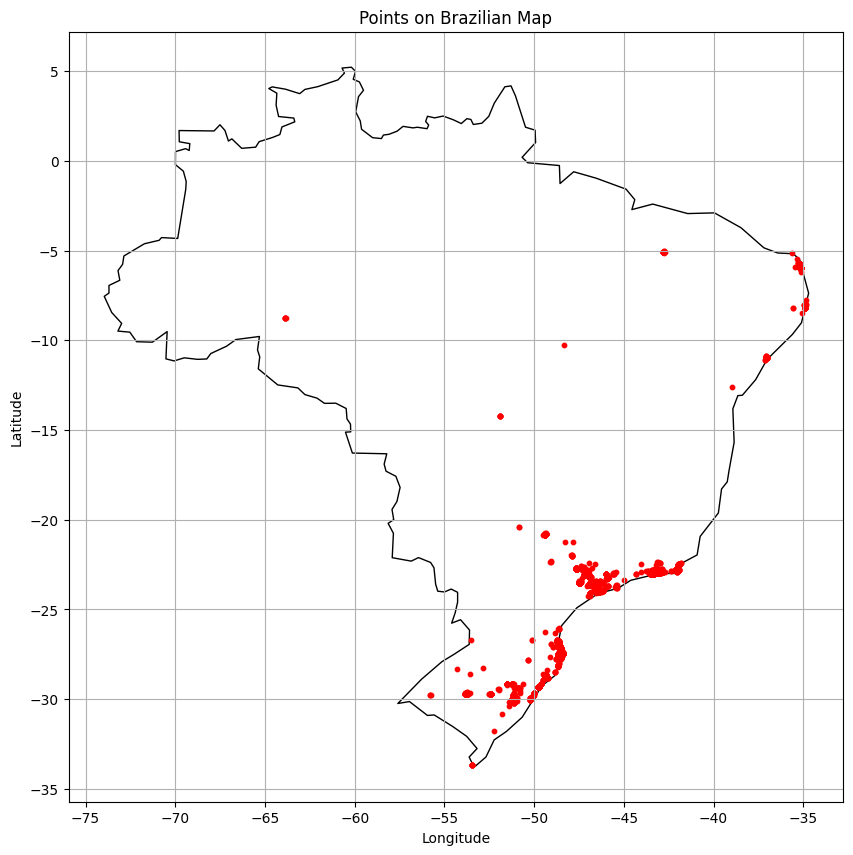

In [181]:
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
brazil = brazil[brazil['name'] == 'Brazil']

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

plt.figure(figsize=(10, 10))

brazil.plot(ax=plt.gca(), color='white', edgecolor='black')

geo_df.plot(ax=plt.gca(), marker='o', color='red', markersize=10)

plt.title('Points on Brazilian Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()

## 4.2 Analyse per property type

In [182]:
df_property_type_count = df['property_type'].value_counts().reset_index()

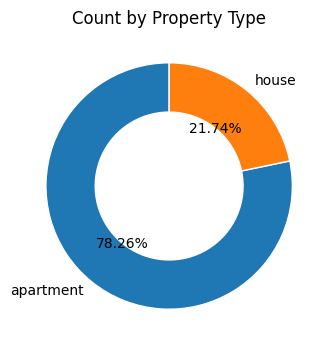

In [183]:
plt.figure(figsize=(4, 4))

plt.pie(df_property_type_count['count'], 
        labels=df_property_type_count['property_type'], 
        autopct='%1.2f%%', 
        startangle=90, 
        wedgeprops=dict(width=0.4, edgecolor='w'))

plt.title('Count by Property Type')

plt.show()

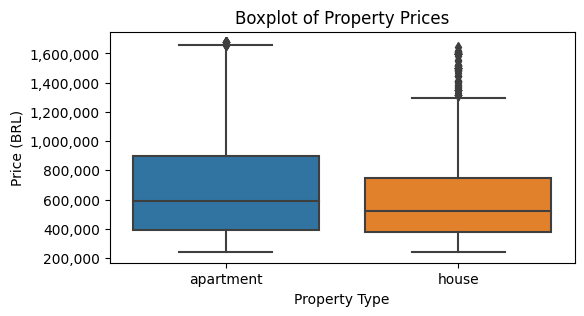

In [184]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df, x='property_type', y='price_brl')

plt.title('Boxplot of Property Prices')
plt.xlabel('Property Type')
plt.ylabel('Price (BRL)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

## 4.3 Analyse per property type and regions

### Apartament

In [185]:
df_ap = df[df['property_type'] == "apartment"]

In [186]:
df_ap_region_count = df_ap['region'].value_counts().reset_index()

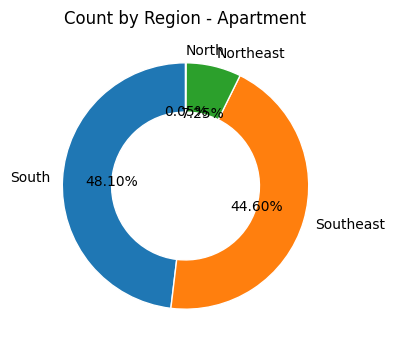

In [187]:
plt.figure(figsize=(4, 4))

plt.pie(df_ap_region_count['count'], 
        labels=df_ap_region_count['region'], 
        autopct='%1.2f%%', 
        startangle=90, 
        wedgeprops=dict(width=0.4, edgecolor='w'))

plt.title('Count by Region - Apartment')

plt.show()

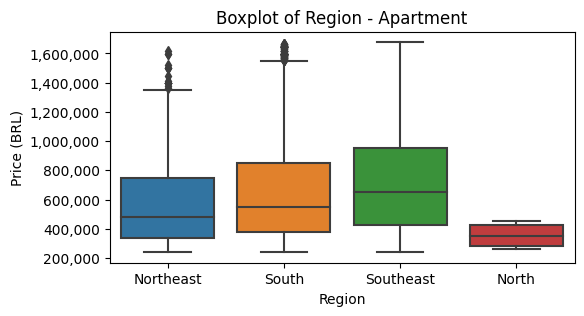

In [188]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df_ap, x='region', y='price_brl')

plt.title('Boxplot of Region - Apartment')
plt.xlabel('Region')
plt.ylabel('Price (BRL)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

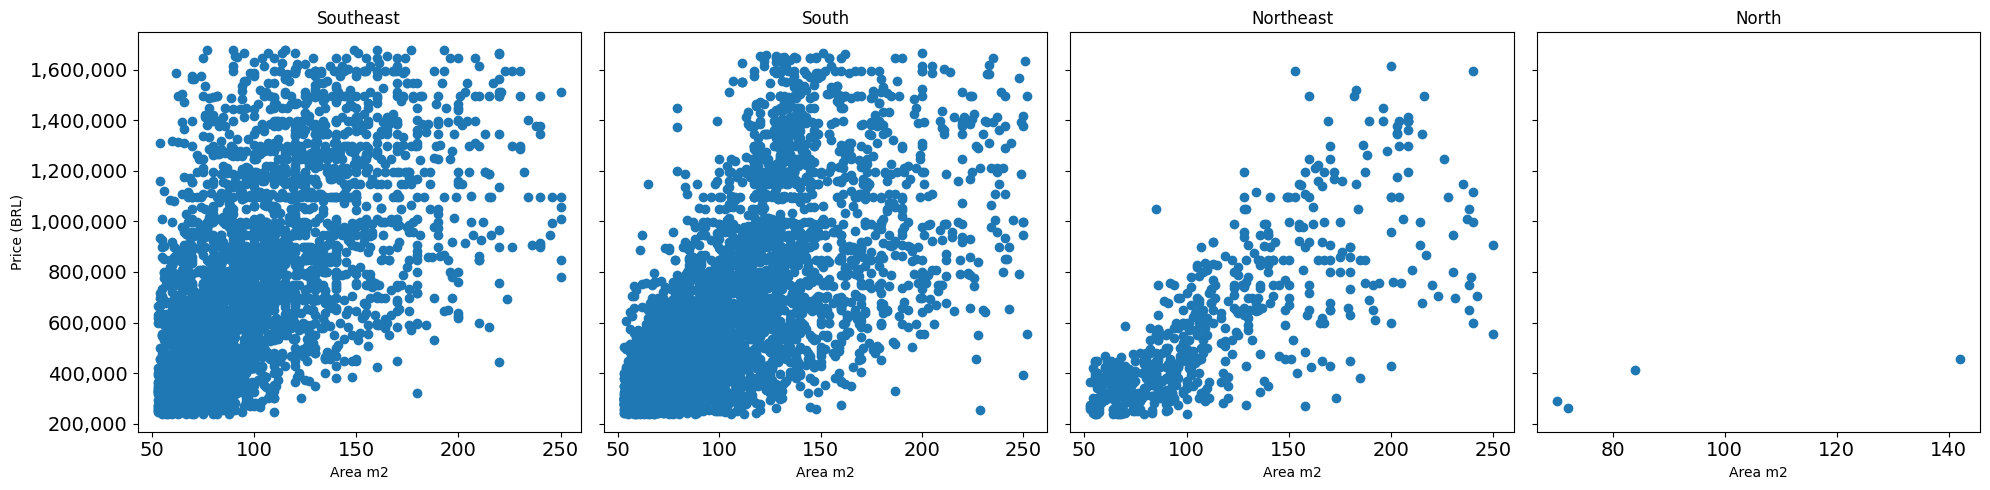

In [189]:
regions = ['Southeast', 'South', 'Northeast', 'North']

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, region in zip(axes, regions):
    df_region = df_ap[df_ap['region'] == region]
    
    ax.scatter(df_region['area_m2'], df_region['price_brl'], alpha=1)
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_xlabel("Area m2")
    ax.set_title(region)
    
    if ax == axes[0]:
        ax.set_ylabel("Price (BRL)")
    
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

### House

In [190]:
df_ho = df[df['property_type'] == "house"]

In [191]:
df_ho_region_count = df_ho['region'].value_counts().reset_index()

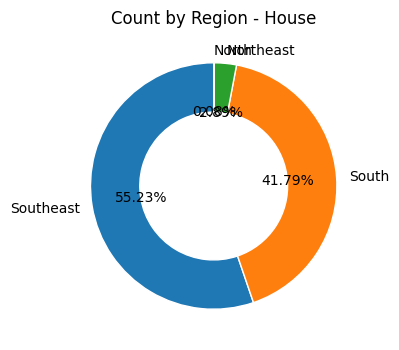

In [192]:
plt.figure(figsize=(4, 4))

plt.pie(df_ho_region_count['count'], 
        labels=df_ho_region_count['region'], 
        autopct='%1.2f%%', 
        startangle=90, 
        wedgeprops=dict(width=0.4, edgecolor='w'))

plt.title('Count by Region - House')

plt.show()

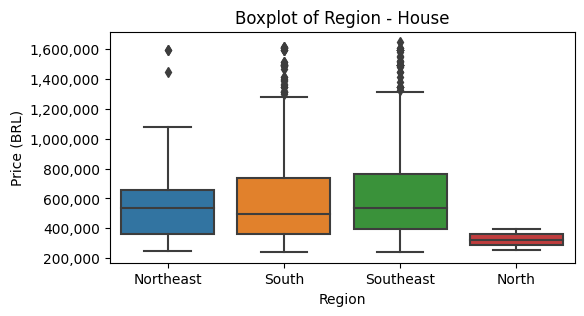

In [193]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=df_ho, x='region', y='price_brl')

plt.title('Boxplot of Region - House')
plt.xlabel('Region')
plt.ylabel('Price (BRL)')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

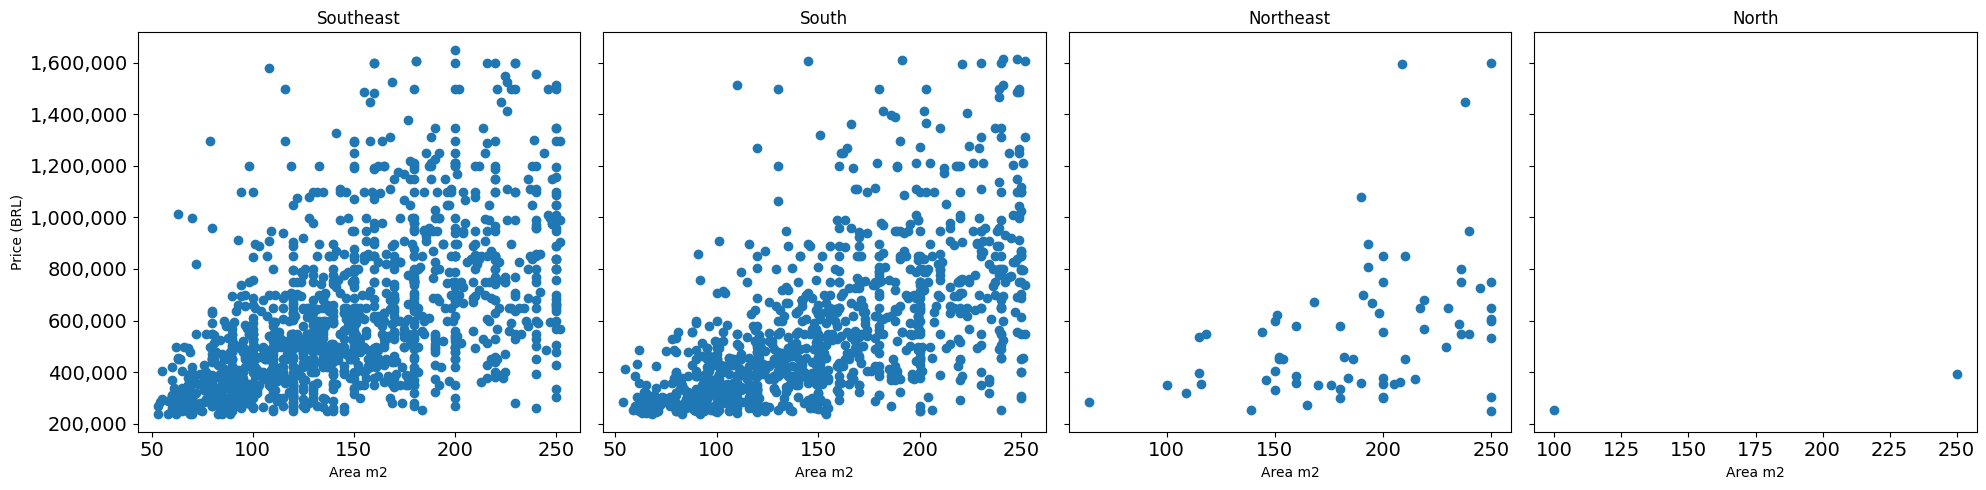

In [194]:
regions = ['Southeast', 'South', 'Northeast', 'North']

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, region in zip(axes, regions):
    df_region = df_ho[df_ho['region'] == region]
    
    ax.scatter(df_region['area_m2'], df_region['price_brl'], alpha=1)
    ax.tick_params(axis='both', which='both', labelsize=14)
    ax.set_xlabel("Area m2")
    ax.set_title(region)
    
    if ax == axes[0]:
        ax.set_ylabel("Price (BRL)")
    
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>],
       [<Axes: title={'center': 'area_m2'}>,
        <Axes: title={'center': 'price_brl'}>]], dtype=object)

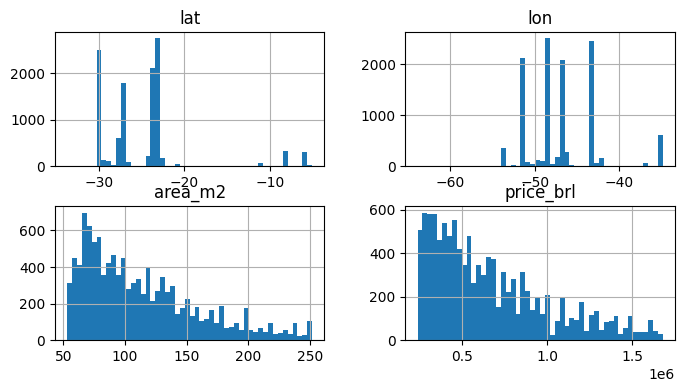

In [195]:
df.hist(bins=50, figsize=(8,4))

# 5 - Regression Model
---

## 5.1 Encode categorical variables

In [196]:
data = {
    'property_type': ['apartment', 'house'],
    'state': ['Sao Paulo', 'Rio Grande do Sul', 'Rio de Janeiro', 'Santa Catarina',
              'Pernambuco', 'Rio Grande do Norte', 'Sergipe', 'Piaui', 
              'Rondonia', 'Tocantins'],
    'region': ['Northeast', 'Southeast', 'Southeast', 'North']
}

encoder = OneHotEncoder(handle_unknown='ignore')

encoded_data = encoder.fit_transform(df[['property_type', 'state', 'region']])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['property_type', 'state', 'region']))

display(encoded_df)

,property_type_apartment,property_type_house,state_Pernambuco,state_Piaui,state_Rio Grande do Norte,state_Rio Grande do Sul,state_Rio de Janeiro,state_Rondonia,state_Santa Catarina,state_Sao Paulo,state_Sergipe,state_Tocantins,region_North,region_Northeast,region_South,region_Southeast
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11288,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
11289,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
11290,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
11291,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## 5.2 Concat numerical variables with encoded

In [209]:
numerical_features = df[['area_m2', 'lat', 'lon']].copy()

X = pd.concat([numerical_features, encoded_df], axis=1)
display(X)

y = df['price_brl']
display(y)

,area_m2,lat,lon,property_type_apartment,property_type_house,state_Pernambuco,state_Piaui,state_Rio Grande do Norte,state_Rio Grande do Sul,state_Rio de Janeiro,state_Rondonia,state_Santa Catarina,state_Sao Paulo,state_Sergipe,state_Tocantins,region_North,region_Northeast,region_South,region_Southeast
0,72.0,-8.134204,-34.906326,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,136.0,-8.126664,-34.903924,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,75.0,-8.125550,-34.907601,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,187.0,-8.120249,-34.895920,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,80.0,-8.142666,-34.906906,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11288,180.0,-23.595098,-46.796448,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
11289,250.0,-23.587495,-46.559401,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
11290,55.0,-23.522029,-46.189290,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
11291,57.0,-23.526443,-46.529182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


0        414222.98
1        848408.53
2        299438.28
3        848408.53
4        464129.36
           ...    
11288    419213.60
11289    429194.89
11290    252398.80
11291    319400.84
11292    289457.01
Name: price_brl, Length: 11293, dtype: float64

## 5.3 Train and Testing Model

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f' MSE: {mse} \n R2: {r2}')

 MSE: 73513023790.55508 
 R2: 0.3905718212840168


# 6 - Random Forest Regressor Model
---

## 6.1 Train and Testing Model

In [224]:
rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f' MSE: {mse_rf} \n R2: {r2_rf}')

 MSE: 41662773443.94776 
 R2: 0.6546126545883715


---